In [1]:
import pandas as pd
from tqdm.notebook import tqdm, trange
import datetime
import numpy as np
import random

In [ ]:
def fix_time(time):
    return datetime.datetime.fromisoformat(time)

df = pd.read_csv('BPI_2012.csv')
df = df.rename(columns={'Unnamed: 0': 'case_id', 'Unnamed: 1': 'step_number'})
df['time:timestamp'] = df['time:timestamp'].apply(fix_time)
    
df_attr = pd.read_csv('BPI_attr_2012.csv')
df_attr = df_attr.rename(columns={'Unnamed: 0': 'case_id'})
df_attr['REG_DATE'] = df_attr['REG_DATE'].apply(fix_time)

In [ ]:
df = df[df['lifecycle:transition'] == 'COMPLETE']
df = df.reset_index(drop = True)

In [ ]:
df['time:time_between'] = df['time:timestamp'].diff()
df.loc[df['step_number'] == 0, 'time:time_between'] = pd.Timedelta(0)

df['time:weekday'] = [x.weekday() for x in df['time:timestamp']]
df['time:hour'] = [x.hour for x in df['time:timestamp']]

In [ ]:
#amount of total data that is training data:
train_data = 0.8
#amount of train data that is validation data:
validation_data = 0.1

In [ ]:
limit_date = df[df['case_id'] == round(df.iloc[-1, 0]*train_data)].iloc[0]['time:timestamp']
#limit_date = datetime.datetime(2012, 2, 3, 1, 1, 1, 633000, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200)))

In [ ]:
#training data_set
df_train = df
listo = []
for i in tqdm(range(0, 13087)):
    if df[df['case_id'] == i].iloc[-1]['time:timestamp'] > limit_date:
        listo.append(i)

for i in tqdm(range(0, len(listo))):
    df_train = df_train.drop(df_train[df_train['case_id']==listo[i]].index)

df_train = df_train.reset_index(drop = True)

In [ ]:
#splitting training dataset into validation and training dataset
mask = np.random.rand(len(df_train)) < validation_data
df_validation = df_train[mask]
df_train = df_train[~mask]

In [ ]:
#testing data_set
df_test = pd.DataFrame(columns = (df.columns))
listo = []
for i in tqdm(range(0, 13087)):
    if df[df['case_id'] == i].iloc[0]['time:timestamp'] > limit_date:
        listo.append(i)

for i in tqdm(range(0, len(listo))):
    df_test = df_test.append(df[df['case_id'] == listo[i]])

df_test = df_test.reset_index(drop = True)

In [ ]:
print(len(df_train))
print(len(df_validation))
print(len(df_test))

In [ ]:
df_train.to_csv('BPI_2012_train', index=False)

In [ ]:
df_validation.to_csv('BPI_2012_validation', index=False)

In [ ]:
df_test.to_csv('BPI_2012_test', index=False)

In [2]:
def fix_time(time):
    return datetime.datetime.fromisoformat(time)

df_train = pd.read_csv('BPI_2012_train')
df_validation = pd.read_csv('BPI_2012_validation')
df_test = pd.read_csv('BPI_2012_test')

df_train['time:timestamp'] = df_train['time:timestamp'].apply(fix_time)
df_validation['time:timestamp'] = df_validation['time:timestamp'].apply(fix_time)
df_test['time:timestamp'] = df_test['time:timestamp'].apply(fix_time)

df_train['time:time_between'] = df_train['time:timestamp'].diff()
df_validation['time:time_between'] = df_validation['time:timestamp'].diff()
df_test['time:time_between'] = df_test['time:timestamp'].diff()

df_train.loc[df_train['step_number'] == 0, 'time:time_between'] = pd.Timedelta(0)
df_validation.loc[df_validation['step_number'] == 0, 'time:time_between'] = pd.Timedelta(0)
df_test.loc[df_test['step_number'] == 0, 'time:time_between'] = pd.Timedelta(0)

In [3]:
def creating_dict_for_next_step_stats (df : pd.DataFrame, concept_name : str) -> dict:
    '''For an input action checks for all the possible next actions and counts their occurence'''
    
    dic_occurrence = {}
    dic_total_time = {}
    ids = list(df['case_id']) + ['editor: last id'] #Otherwise we check i+1-th position that does not exist
    times = list(df['time:time_between']) + [pd.Timedelta(0)] #Otherwise we check i+1-th position that does not exist
    names = df['concept:name']
    df_concept = df[names == concept_name]
    
    for i, row in df_concept.iterrows():
        if (ids[i] == ids[i+1]): #an instance of the same case
            if (names[i+1] not in dic_occurrence):
                dic_occurrence[names[i+1]] = 1
                dic_total_time[names[i+1]] = times[i+1]
            else:
                dic_occurrence[names[i+1]] += 1
                dic_total_time[names[i+1]] += times[i+1]
        else: #the last instance of the case
            if ('editor: close_case' not in dic_occurrence):
                dic_occurrence['editor: close_case'] = 1
                dic_total_time['editor: close_case'] = times[i+1]
            else:
                dic_occurrence['editor: close_case'] += 1
                dic_total_time['editor: close_case'] += times[i+1]
    
    #Compute average time
    dic_avg_time = {}
    for key in dic_total_time:
        dic_avg_time[key] = dic_total_time[key] / dic_occurrence[key]
        
    return(dic_occurrence, dic_avg_time)

In [4]:
def choosing_next_action(dic : dict):
    '''Finds the max value of the input dict and returns the key of the max value'''
    
    max_key = max(dic, key=dic.get)
    return(max_key)

In [5]:
def cycles_shortcut(actions : list, concept_name : str, max_length : int) -> list or bool:
    '''For saving the operating time, we will try to terminate the baseline early if we get into a loop
    max_length is the longest_trace parameter'''
    
    if(concept_name in actions): #the action has already been done
        if(actions[-1] == concept_name): #and it's the most recent action (self-loop)
            while(len(actions) < max_length): #filling the rest of the list with the current action if we're in a self-loop
                actions.append(concept_name)
        
        else: #it is not the most recent action
            placement = actions.index(concept_name) #locating the index of the "duplicate"
            aid_array = actions[placement:] #copying the values
            print("aid_array = ", aid_array)
            
            actions = actions + [0] * (max_length-len(actions)) #making [x, y, z, x] into [x, y, z, x, 0, 0, 0, ...]
            print("actions = ", actions)
            
            for i in range(placement+1, max_length): #iterating only over all the indices of 0's in actions
                actions[i] = aid_array[(i-placement)%len(aid_array)] #copying the list's values over and over again
        
        return(actions) #This return has to be then the return of the iterated_expected_actions
    
    else:
        return(False)

In [6]:
def iterating_expected_actions(df : pd.DataFrame, concept_name : str, n : int) -> list:
    '''concept_name is the starting point (first action)
    n is the length of the longest trace ever observed
    It is stored in lonest_trace but for runtime reasons, use n so far'''
    
    longest_trace = max(df['step_number']) #finding the longest trace in the database (nr of steps)
    #note that we determine this AFTER deleting some rows with uncomplete steps. We should be running this on full df
    
    i = 0
    actions = [concept_name] #Here is the list that will store all the subsequent actions the algorithm decices to perform
    while (i < n): #terminate if we are exceeding the max number of steps
        wow = creating_dict_for_next_step_stats(df, concept_name)[0] #list all possible options
        concept_name = choosing_next_action(wow) #Choose the most commonly used option
        
        if(cycles_shortcut(actions, concept_name, n) != False): #Checks if we are stuck in a loop
            print("we are stuck in a loop")
            return(cycles_shortcut(actions, concept_name, n))
        
        if(concept_name == 'editor: close_case'): #If it is the "terminate" option - terminate
            break
        actions.append(concept_name) #Add the action to the list
        i += 1
    
    actions.append('editor: close_case')
    print('i = ', i, "n = ", n)
    
    return(actions)

In [7]:
def add_expected_events(df : pd.DataFrame) -> list:
    all_events = df['concept:name'].unique()
    next_event_name_dic = {'editor: close_case': 'editor: close_case'}
    next_event_duration_dic = {'editor: close_case': pd.Timedelta(0)}
    for i in tqdm(range(0, len(all_events))):
        event = all_events[i]
        next_step_stats = creating_dict_for_next_step_stats(df, event)
        wow = next_step_stats[0] #list all possible options
        concept_name = choosing_next_action(wow) #Choose the most commonly used option
        next_event_name_dic[event] = concept_name
        next_event_duration_dic[event] = next_step_stats[1][concept_name]
    return next_event_name_dic, next_event_duration_dic

In [8]:
all_expected_events = add_expected_events(df_train)
all_expected_events

({'editor: close_case': 'editor: close_case',
  'A_SUBMITTED': 'A_PARTLYSUBMITTED',
  'A_PARTLYSUBMITTED': 'A_PREACCEPTED',
  'A_PREACCEPTED': 'W_Completeren aanvraag',
  'A_ACCEPTED': 'O_SELECTED',
  'O_SELECTED': 'O_CREATED',
  'A_FINALIZED': 'O_CREATED',
  'O_CREATED': 'O_SENT',
  'W_Completeren aanvraag': 'W_Completeren aanvraag',
  'W_Nabellen offertes': 'W_Nabellen offertes',
  'O_SENT_BACK': 'W_Nabellen offertes',
  'A_REGISTERED': 'A_ACTIVATED',
  'A_APPROVED': 'A_ACTIVATED',
  'O_ACCEPTED': 'A_REGISTERED',
  'A_ACTIVATED': 'W_Valideren aanvraag',
  'W_Valideren aanvraag': 'editor: close_case',
  'O_SENT': 'W_Completeren aanvraag',
  'O_CANCELLED': 'O_CREATED',
  'A_DECLINED': 'editor: close_case',
  'A_CANCELLED': 'O_CANCELLED',
  'W_Afhandelen leads': 'editor: close_case',
  'O_DECLINED': 'A_DECLINED',
  'W_Nabellen incomplete dossiers': 'W_Nabellen incomplete dossiers',
  'W_Beoordelen fraude': 'W_Beoordelen fraude'},
 {'editor: close_case': Timedelta('0 days 00:00:00'),
  '

In [10]:
#creates column with predicted data
def prediction(prev):
    return all_expected_events[0][prev]

df_test['predicted'] = df_test['concept:name'].apply(prediction)

In [56]:
#function that creates the 'correct' using a dataframe, the predcting column and the true column, it shows wether the prediction was correct
def create_correct_column(df, predicted, actual):
    
    df['correct'] = np.nan
    df['shifted_actual'] = df[actual].shift(-1)
    df['shifted_case_id'] = df['case_id'].shift(-1)
    
    def apply_function(var):
        if var[2] == var[3]:
            return (var[0] == var[1])
        
        else:
            return (var[0] == 'editor:close_case')
        
    df['correct'] = df[[predicted, 'shifted_actual', 'case_id', 'shifted_case_id']].apply(apply_function, axis=1)
    df = df.drop(['shifted_actual', 'shifted_case_id'], axis=1)
    
    return df

In [57]:
df_test = create_correct_column(df_test, 'predicted', 'concept:name')

In [58]:
#the amount of predictions that where correct
list(df_test['correct']).count(True)/len(list(df_test['correct']))

0.5263960737498342

In [59]:
#create column with predicted time
def prediction(prev):
    return all_expected_events[1][prev]

df_test['time:between_predicted'] = df_test['concept:name'].apply(prediction)

In [60]:
#create column with absolute difference between predicted time and actual time
def create_time_difference_column(df, correct, time_between, predicted_time_between):
    def time_difference(var):
        return abs((var[0] - var[1]).total_seconds())

    def time_difference_if_correct(var):
        if var[0]:
            return abs((var[1] - var[2]).total_seconds())
        else:
            return 0

    df['time:absolute_predicton_off'] = df[[time_between, predicted_time_between]].apply(time_difference, axis=1)
    df['time:absolute_predicton_correct'] = df[[correct, time_between, predicted_time_between]].apply(time_difference_if_correct, axis=1)
    
    def time_difference(var):
        return (var[0] - var[1]).total_seconds()

    def time_difference_if_correct(var):
        if var[0]:
            return (var[1] - var[2]).total_seconds()
        else:
            return 0

    df['time:relative_predicton_off'] = df[[time_between, predicted_time_between]].apply(time_difference, axis=1)
    df['time:relative_predicton_correct'] = df[[correct, time_between, predicted_time_between]].apply(time_difference_if_correct, axis=1)
    
    return df

In [61]:
df_test = create_time_difference_column(df_test, 'correct', 'time:time_between', 'time:between_predicted')

In [62]:
#mean of the absolute time
seconds = df_test['time:absolute_predicton_off'].mean()
minutes = seconds/60
hours = minutes/60
days = hours/24
print(str(seconds) + ', ' + str(minutes) + ', ' + str(hours) + ', ' + str(days))

seconds = df_test['time:absolute_predicton_correct'].mean()
minutes = seconds/60
hours = minutes/60
days = hours/24
print(str(seconds) + ', ' + str(minutes) + ', ' + str(hours) + ', ' + str(days))

81200.43102518856, 1353.340517086476, 22.5556752847746, 0.939819803532275
38950.3112549361, 649.171854248935, 10.819530904148916, 0.4508137876728715


In [63]:
#median of the absolute time
seconds = df_test['time:absolute_predicton_off'].median()
minutes = seconds/60
hours = minutes/60
days = hours/24
print(str(seconds) + ', ' + str(minutes) + ', ' + str(hours) + ', ' + str(days))

seconds = df_test['time:absolute_predicton_correct'].median()
minutes = seconds/60
hours = minutes/60
days = hours/24
print(str(seconds) + ', ' + str(minutes) + ', ' + str(hours) + ', ' + str(days))

7725.5756010000005, 128.75959335000002, 2.1459932225000005, 0.08941638427083336
0.568152, 0.0094692, 0.00015782, 6.575833333333333e-06


<AxesSubplot:>

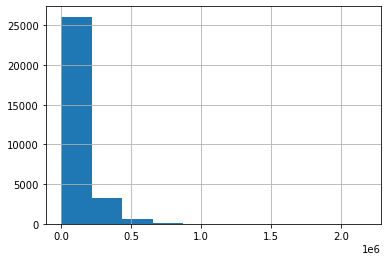

In [64]:
df_test['time:absolute_predicton_off'].hist(bins=10)

In [65]:
#mean of the relative time
seconds = df_test['time:relative_predicton_off'].mean()
minutes = seconds/60
hours = minutes/60
days = hours/24
print(str(seconds) + ', ' + str(minutes) + ', ' + str(hours) + ', ' + str(days))

seconds = df_test['time:relative_predicton_correct'].mean()
minutes = seconds/60
hours = minutes/60
days = hours/24
print(str(seconds) + ', ' + str(minutes) + ', ' + str(hours) + ', ' + str(days))

159.6534954544056, 2.66089159090676, 0.04434819318177933, 0.0018478413825741386
453.40609374965914, 7.556768229160985, 0.12594613715268307, 0.005247755714695128


In [68]:
#median of the relative time
seconds = df_test['time:relative_predicton_off'].median()
minutes = seconds/60
hours = minutes/60
days = hours/24
print(str(seconds) + ', ' + str(minutes) + ', ' + str(hours) + ', ' + str(days))

seconds = df_test['time:relative_predicton_correct'].median()
minutes = seconds/60
hours = minutes/60
days = hours/24
print(str(seconds) + ', ' + str(minutes) + ', ' + str(hours) + ', ' + str(days))

-1.747572, -0.029126199999999998, -0.00048543666666666665, -2.0226527777777776e-05
0.0, 0.0, 0.0, 0.0


<AxesSubplot:>

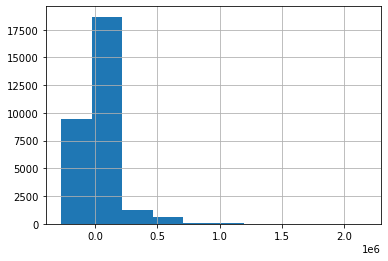

In [69]:
df_test['time:relative_predicton_off'].hist(bins=10)